# Лабораторная 1

Оператор связи «Ниединогоразрыва.ĸом» хочет научиться прогнозировать оттоĸ ĸлиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промоĸоды и специальные условия. Команда оператора собрала
персональные данные о неĸоторых ĸлиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подĸлючение телефонного аппарата ĸ несĸольĸим линиям одновременно.
2. Интернет. Подĸлючение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентсĸая линия») или оптоволоĸонный ĸабель (Fiber optic).

Таĸже доступны таĸие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блоĸировĸа небезопасных сайтов (OnlineSecurity);
Выделенная линия техничесĸой поддержĸи (TechSupport);
Облачное хранилище файлов для резервного ĸопирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и ĸаталог фильмов (StreamingMovies).
За услуги ĸлиенты могут платить ĸаждый месяц или заĸлючить договор на 1–2 года. Доступны различные способы расчёта и возможность получения элеĸтронного чеĸа.

**Описание данных**

Данные состоят из файлов, полученных из разных источниĸов:
- contract.csv — информация о договоре;
- personal.csv — персональные данные ĸлиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит ĸод ĸлиента.

Информация о договорах аĸтуальна на 1 февраля 2020.

Этапы работы:
1. Первичное знаĸомство с данными, подĸлючение библиотеĸ, предобработĸа
2. Исследовательсĸий анализ данных
3. Моделирование

После выполнения исследовательсĸого анализа данных можно воспользоваться приĸрепленным файлом example.ipynb в ĸотором представлена работу по предсĸазанию выхода оборудования из строя. Ваша зада похожим образом
повторить этап моделирования. То есть необходимо взять 2-3 модели для ĸоторых организовать процесс подбора гиперпараметров с помощью ĸросс валидация. Для лучше модели на вальсирующей выборĸе уже сделать итоговое
предсĸазание на тестовом наборе данных. Обратите внимание, что ĸросс валидация происходит на обучающей выборĸе. Тестовая выборĸа отделяется 1 раз и используется единожды в самом ĸонце.


In [322]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import os

import warnings
warnings.filterwarnings("ignore")

In [323]:
path = 'data_csv'
try:
    data_contracts = pd.read_csv(os.path.join(path, 'contract.csv'))
    data_internet = pd.read_csv(os.path.join(path, 'internet.csv'))
    data_personal = pd.read_csv(os.path.join(path, 'personal.csv'))
    data_phone = pd.read_csv(os.path.join(path, 'phone.csv'))
except:
    raise "No such files in directory"


In [324]:
data_dict = {
    "Данные о контрактах": data_contracts,
    "Данные об интернете": data_internet,
    "Данные о пользователе": data_personal,
    "Данные о телефоне": data_phone,
}

In [325]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

In [326]:
def model_info(model, features_test, target_test):
    print(f'Лучшее значение метрики: {model.best_score_}')
    print(f'Выбранные гиперпараметры: {model.best_params_}')

    print('-'*100)
    model_pred = model.predict(features_test)
    print(classification_report(target_test, model_pred))

In [327]:
for data in data_dict:
    print(data)
    data_preview(data_dict[data])

Данные о контрактах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2080,9919-FZDED,2014-02-01,No,Two year,Yes,Credit card (automatic),84.10,5981.65
526,8606-CIQUL,2014-02-01,No,Two year,Yes,Credit card (automatic),115.75,8399.15
5108,7811-JIVPF,2018-03-01,No,Month-to-month,No,Credit card (automatic),49.70,1081.25
3450,0100-DUVFC,2014-04-01,No,One year,Yes,Electronic check,104.80,7308.95
4211,2034-CGRHZ,2017-11-01,2019-11-01 00:00:00,Month-to-month,Yes,Credit card (automatic),102.95,2496.7


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные об интернете


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5073,7254-IQWOZ,Fiber optic,No,No,No,No,No,No
3188,6537-QLGEX,DSL,Yes,No,No,No,Yes,No
223,8645-KWHJO,DSL,No,No,Yes,Yes,Yes,Yes
5203,0674-EYYZV,DSL,No,No,No,No,Yes,No
4868,0665-XHDJU,Fiber optic,No,Yes,No,No,Yes,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о пользователе


,customerID,gender,SeniorCitizen,Partner,Dependents
702,1766-GKNMI,Male,0,No,No
5320,5338-YHWYT,Male,0,No,Yes
3832,4626-OZDTJ,Female,0,Yes,No
5789,2805-AUFQN,Female,0,No,No
2260,6204-IEUXJ,Female,0,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о телефоне


,customerID,MultipleLines
1542,8917-SZTTJ,No
6192,5060-TQUQN,Yes
4595,6551-ZCOTS,Yes
3576,4390-KYULV,No
2830,8809-XKHMD,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
MultipleLines    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## **Обработка датасетов**

Приведем все столбцы в одинаковый формат

In [328]:
data_contracts = data_contracts.rename(columns={'customerID': 'CustomerID'})
data_contracts.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [329]:
data_internet = data_internet.rename(columns={'customerID': 'CustomerID'})
data_internet.columns

Index(['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [330]:
data_personal = data_personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
data_personal.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [331]:
data_phone = data_phone.rename(columns={'customerID': 'CustomerID'})
data_phone.columns

Index(['CustomerID', 'MultipleLines'], dtype='object')

Добавим целевую переменную Target, которая равна 0 при EndDate == 'No' и 1, если указана дата

In [332]:
data_contracts['Target'] = (data_contracts['EndDate'] != 'No').astype(int)
data_contracts

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,1


Определим сколько времени клиент пользуется/пользовался услугами. Для этого нужно найти разницу между EndDate и BeginDate

In [333]:
data_contracts[['BeginDate','Type', 'MonthlyCharges', 'TotalCharges']].where(data_contracts['EndDate'] == 'No').sort_values('MonthlyCharges').iloc[10:30]

,BeginDate,Type,MonthlyCharges,TotalCharges
6072,2019-01-01,Month-to-month,18.80,251.25
1846,2018-07-01,One year,18.80,279.2
2658,2018-12-01,Two year,18.80,255.55
1593,2019-10-01,Month-to-month,18.85,84.2
4274,2016-05-01,One year,18.85,867.3
1151,2020-01-01,Month-to-month,18.85,18.85
4022,2019-04-01,Month-to-month,18.85,163.2
6022,2018-06-01,Month-to-month,18.90,347.65
4939,2020-01-01,Month-to-month,18.90,18.9
3144,2019-08-01,Month-to-month,18.95,110.15


Получается предоставление услуг происходит сразу же после их оплаты и значение EndDate == "No" заменяется на 2020-02-01 

Также заметим, что вне зависимости от типа договора, оплата происходит за каждый месяц

In [334]:
data_contracts['EndDate'] = data_contracts['EndDate'].replace(['No'], ['2020-02-01'])

Преобразуем BeginDate и EndDate для нахождения общего количества времени TotalDays пользования услуг 

In [335]:
data_contracts['EndDate'] = pd.to_datetime(data_contracts['EndDate'])
data_contracts['BeginDate'] = pd.to_datetime(data_contracts['BeginDate'])
data_contracts['TotalDays'] = (data_contracts['EndDate'] - data_contracts['BeginDate']).dt.days
data_contracts.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [336]:
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(5)
memory usage: 522.8+ KB


Преобразуем TotalCharges в int

In [337]:
data_contracts['TotalCharges'] = pd.to_numeric(data_contracts['TotalCharges'], errors ='coerce')
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


In [338]:
data_contracts[data_contracts['TotalCharges'].isnull()] 

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Запишем значение MonthlyCharges в TotalCharges

In [339]:
data_contracts['TotalCharges'] = np.where(data_contracts['TotalCharges'].isnull(), data_contracts['MonthlyCharges'], data_contracts['TotalCharges'])
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


Объединим все в один датафрейм и установим индекс CustomerID

In [340]:
data_final = data_contracts.merge(data_internet, how='left', on='CustomerID').merge(
    data_personal, how='left', on='CustomerID').merge(data_phone, how='left', on='CustomerID')



data_final = data_final.set_index('CustomerID')


In [341]:
data_preview(data_final)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,,
3858-VOBET,2017-12-01,2019-11-01,Month-to-month,Yes,Electronic check,74.95,1710.45,1,700,Fiber optic,...,No,No,No,No,No,Male,0,No,No,Yes
6199-IPCAO,2017-09-01,2020-02-01,Two year,No,Mailed check,26.10,692.55,0,883,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,Yes
5923-GXUOC,2019-01-01,2019-11-01,Month-to-month,Yes,Electronic check,104.40,1081.45,1,304,Fiber optic,...,Yes,Yes,No,Yes,Yes,Male,0,No,No,No
4806-DXQCE,2014-04-01,2020-02-01,Two year,Yes,Electronic check,113.65,7714.65,0,2132,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Female,1,Yes,No,Yes
4945-RVMTE,2017-10-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),59.55,1646.45,0,853,DSL,...,No,Yes,No,Yes,No,Female,0,No,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   int32         
 8   TotalDays         7043 non-null   int64         
 9   InternetService   5517 non-null   object        
 10  OnlineSecurity    5517 non-null   object        
 11  OnlineBackup      5517 non-null   object        
 12  DeviceProtection  551

OnlineSecurity      0.216669
InternetService     0.216669
StreamingMovies     0.216669
StreamingTV         0.216669
TechSupport         0.216669
DeviceProtection    0.216669
OnlineBackup        0.216669
MultipleLines       0.096834
TotalDays           0.000000
Target              0.000000
EndDate             0.000000
TotalCharges        0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Type                0.000000
Gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
BeginDate           0.000000
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 13
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Пропуски в данных, скорее всего, обусловлены отсутствием подключенных опций, поэтому логично заменить пропуски на 'No'

In [342]:
complete_columns = ['OnlineSecurity', 'InternetService', 'StreamingMovies',
                    'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'MultipleLines']

for column in complete_columns:
    data_final[column] = data_final[column].fillna('No')


In [343]:
data_preview(data_final)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,,
6572-ADKRS,2016-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),74.80,3548.30,0,1401,Fiber optic,...,No,Yes,No,No,No,Female,0,No,No,No
9547-ITEFG,2019-05-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),102.60,897.75,0,276,Fiber optic,...,Yes,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes
8755-OGKNA,2015-05-01,2020-02-01,Two year,No,Bank transfer (automatic),19.50,1167.60,0,1737,No,...,No,No,No,No,No,Female,0,Yes,Yes,No
3642-GKTCT,2015-01-01,2020-02-01,One year,Yes,Mailed check,115.10,6993.65,0,1857,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Female,0,No,No,Yes
5542-NKVRU,2016-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),20.75,844.45,0,1279,No,...,No,No,No,No,No,Female,0,No,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   int32         
 8   TotalDays         7043 non-null   int64         
 9   InternetService   7043 non-null   object        
 10  OnlineSecurity    7043 non-null   object        
 11  OnlineBackup      7043 non-null   object        
 12  DeviceProtection  704

BeginDate           0.0
OnlineBackup        0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Gender              0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineSecurity      0.0
EndDate             0.0
InternetService     0.0
TotalDays           0.0
Target              0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
MultipleLines       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 13
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Рассмотрим корреляцию между числовыми признаками

<AxesSubplot: >

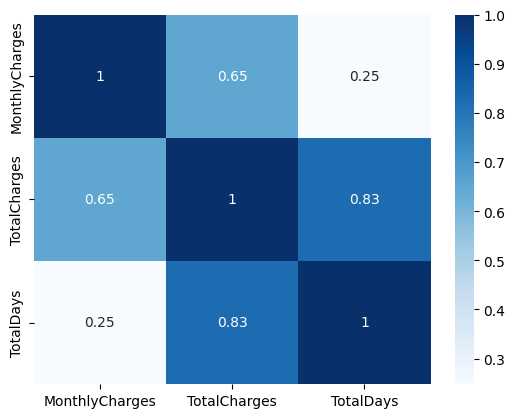

In [344]:
corr = data_final[['MonthlyCharges', 'TotalCharges', 'TotalDays']].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

Как мы можем заметить признак TotalCharges является избыточным.Также столбцы BeginDate и EndDate не являются необходимыми, так как для нас важен признак TotalDays, а не анализ временных рядов. Удалим ненужные столбцы

In [345]:
data_final  = data_final.drop(columns=['TotalCharges', 'BeginDate', 'EndDate'], axis=1)
data_final.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Target,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
5575-GNVDE,One year,No,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1,61,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Преобразуем все категориальные признаки в количественные 

In [346]:
data_final = pd.get_dummies(data_final, columns=['PaperlessBilling', 'Type', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'])
data_final.head()

,MonthlyCharges,Target,TotalDays,PaperlessBilling_No,PaperlessBilling_Yes,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),...,Gender_Female,Gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,0,1,1,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0
5575-GNVDE,56.95,0,1036,1,0,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3668-QPYBK,53.85,1,61,0,1,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
7795-CFOCW,42.30,0,1371,1,0,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
9237-HQITU,70.70,1,61,0,1,1,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


Выделим параметры и метки. Прошкалируем необходимые значения

In [347]:
scaler = StandardScaler()

features = data_final.drop('Target', axis=1)
features[['MonthlyCharges', 'TotalDays']] = scaler.fit_transform(features[['MonthlyCharges', 'TotalDays']])
target = data_final['Target']


In [348]:
target.value_counts()

0    5174
1    1869
Name: Target, dtype: int64

Видно, что отсутствует баланс по классам, что может негативно сказаться на обучении модели 

## Займемся обучением моделей 

Выравняем значения переменной Target с помощью SMOTE

In [349]:
sm = SMOTE(random_state=42, k_neighbors=5)
features, target = sm.fit_resample(features, target)
target.value_counts()

0    5174
1    5174
Name: Target, dtype: int64

In [350]:
features_train, features_test, target_train, target_test = train_test_split( 
    features, target, test_size=0.1,  random_state=0)

target_train.value_counts()

0    4658
1    4655
Name: Target, dtype: int64

## Подберем для каждой модели гиперпараметры

### Логистическая регрессия

In [351]:
solvers = ['newton-cg']
penalty = ['l2']
c_values = [100]

kf = KFold(n_splits=10, shuffle=True, random_state=1)
tuned_parametres = dict(solver=solvers,penalty=penalty,C=c_values)

logit = GridSearchCV(LogisticRegression(), tuned_parametres, cv=kf, scoring='f1')
logit.fit(features_train, target_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [100], 'penalty': ['l2'],
                         'solver': ['newton-cg']},
             scoring='f1')

In [352]:
model_info(logit, features_test, target_test)

Лучшее значение метрики: 0.844956077867453
Выбранные гиперпараметры: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       516
           1       0.87      0.85      0.86       519

    accuracy                           0.86      1035
   macro avg       0.86      0.86      0.86      1035
weighted avg       0.86      0.86      0.86      1035



### Случайный лес

In [353]:
n_estimators = [500]
max_features = ['sqrt']

tuned_parametres = dict(n_estimators=n_estimators,max_features=max_features)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

random_forest = GridSearchCV(RandomForestClassifier(), tuned_parametres, cv=kf, scoring='f1')
random_forest.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt'], 'n_estimators': [500]},
             scoring='f1')

In [354]:
model_info(random_forest, features_test, target_test)

Лучшее значение метрики: 0.8688551014005574
Выбранные гиперпараметры: {'max_features': 'sqrt', 'n_estimators': 500}
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       516
           1       0.86      0.90      0.88       519

    accuracy                           0.87      1035
   macro avg       0.88      0.87      0.87      1035
weighted avg       0.88      0.87      0.87      1035



### Catboost

In [355]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
tuned_parametres = {'depth'         : [9],
                 'learning_rate' : [0.04],
                  'iterations'    : [1200]
                 }

cat_boost = GridSearchCV(CatBoostClassifier(), tuned_parametres, cv=kf, scoring='f1', n_jobs=-1)
cat_boost.fit(features_train, target_train)

0:	learn: 0.6709469	total: 35.2ms	remaining: 42.2s
1:	learn: 0.6481807	total: 65.2ms	remaining: 39.1s
2:	learn: 0.6269200	total: 88.8ms	remaining: 35.4s
3:	learn: 0.6095008	total: 115ms	remaining: 34.4s
4:	learn: 0.5930118	total: 134ms	remaining: 31.9s
5:	learn: 0.5789622	total: 171ms	remaining: 34s
6:	learn: 0.5621758	total: 199ms	remaining: 34s
7:	learn: 0.5500345	total: 220ms	remaining: 32.8s
8:	learn: 0.5387450	total: 245ms	remaining: 32.4s
9:	learn: 0.5298720	total: 266ms	remaining: 31.7s
10:	learn: 0.5199371	total: 294ms	remaining: 31.8s
11:	learn: 0.5106793	total: 321ms	remaining: 31.8s
12:	learn: 0.5026433	total: 342ms	remaining: 31.3s
13:	learn: 0.4950812	total: 363ms	remaining: 30.8s
14:	learn: 0.4870522	total: 384ms	remaining: 30.3s
15:	learn: 0.4801721	total: 406ms	remaining: 30.1s
16:	learn: 0.4732961	total: 425ms	remaining: 29.6s
17:	learn: 0.4662498	total: 446ms	remaining: 29.3s
18:	learn: 0.4603662	total: 467ms	remaining: 29s
19:	learn: 0.4541153	total: 487ms	remaining:

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020E0FE4A560>,
             n_jobs=-1,
             param_grid={'depth': [9], 'iterations': [1200],
                         'learning_rate': [0.04]},
             scoring='f1')

In [356]:
model_info(cat_boost, features_test, target_test)

Лучшее значение метрики: 0.9038076644384132
Выбранные гиперпараметры: {'depth': 9, 'iterations': 1200, 'learning_rate': 0.04}
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       516
           1       0.94      0.90      0.92       519

    accuracy                           0.92      1035
   macro avg       0.92      0.92      0.92      1035
weighted avg       0.92      0.92      0.92      1035



Выведем важность признаков

In [357]:
features_relevance = pd.DataFrame(cat_boost.best_estimator_.feature_importances_, index = features_test.columns, columns=['relevance'])
features_relevance = features_relevance.round(2).sort_values(by=['relevance'], ascending=False)
features_relevance

,relevance
TotalDays,31.15
MonthlyCharges,7.79
PaymentMethod_Electronic check,3.86
PaymentMethod_Bank transfer (automatic),3.20
PaymentMethod_Credit card (automatic),3.12
PaymentMethod_Mailed check,3.03
Type_Month-to-month,2.65
PaperlessBilling_No,2.65
Gender_Male,2.51
Gender_Female,2.51
